In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

from sklearn.datasets import load_diabetes
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [25]:
GOAL = ['target']
FEATURES = ['age','sex','bmi','bp',
            's1','s2','s3',
            's4','s5','s6']
IGNORED_FEATURES = [] # a placeholder for irrelevant features
TRAIN_FEATURES = list(set([c for c in FEATURES if c not in IGNORED_FEATURES]))
CATEGORICAL_FEATURES = [] # features that require pre-processing

over_sampling = False

In [45]:
def run_load_data():
    print ('load_data - START')
    diabetes = load_diabetes()
    data = pd.DataFrame(data= np.c_[diabetes['data'], \
                                     diabetes['target']],
                        columns= ['age','sex','bmi','bp',
                                  's1','s2','s3',
                                  's4','s5','s6',
                                  'target'] 
                        )
    
    print ('load_data - END')
    return data

In [27]:
def run_train_test_split(data):
    print ('train_test_split - START')
    train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
    print ('train_test_split - END')
    return train_df, test_df

In [28]:
def run_pre_processing(train_df, test_df):
    print ('pre_processing - START')  
    # TODO: Fill NULL with Mean / Median / -1
    
    # Pre-processing non-numeric values using numeric encoding
    # Why use numeric encoding over one hot encoding:
    # https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931
    for f in CATEGORICAL_FEATURES:
        lbl = LabelEncoder()
        lbl.fit(list(train_df[f].values) + list(test_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))
    print ('pre_processing - END') 
    return train_df, test_df

In [29]:
def run_x_y_split(train_df, test_df):
    print ('x_y_split - START')
    X_train = train_df[TRAIN_FEATURES]
    y_train = train_df[GOAL]
    X_test = test_df[TRAIN_FEATURES]
    y_test = test_df[GOAL]
    print ('x_y_split - END')
    return X_train, y_train, X_test, y_test

In [30]:
def run_over_sampling(X_train, y_train):
    print ('over_sampling - START')
#     TODO: Figure how to oversample using SMOTE 
#     X_train, y_train = SMOTE().fit_sample(X_train, y_train)
#     X_train, y_train = RandomOverSampler().fit_sample(X_train, y_train)
    print ('over_sampling - END')
    return X_train, y_train

In [62]:
def run_grid_search(X_train, y_train):
    print ('grid_search - START')
    dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    gbm_param_grid = {
        'learning_rate': [0.1, 0.01],
        'max_depth': [2, 3],
        'n_estimators': [50,100],
        'gamma': [2, 5],
        'colsample_bytree': [0.3, 0.7],
        'colsample_bylevel': [0.8, 1]
    }
    gbm = xgb.XGBRegressor()
    
    # Perform grid search
    grid = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                            scoring='neg_mean_absolute_error', cv=5, verbose=1)
    grid.fit(X_train, y_train)

    # Print the best parameters & metric
    print("Best parameters found: ", grid.best_params_)
    print("Best MAE found: ", grid.best_score_)

    best_learning_rate = grid.best_params_["learning_rate"]
    best_max_depth = grid.best_params_["max_depth"]
    best_n_estimators = grid.best_params_["n_estimators"]    
    best_gamma = grid.best_params_["gamma"]   
    best_colsample_bytree = grid.best_params_["colsample_bytree"] 
    best_colsample_bylevel = grid.best_params_["colsample_bylevel"]     
    
    print ('grid_search - END')    
    return best_learning_rate, best_max_depth, best_n_estimators, best_gamma, best_colsample_bytree, best_colsample_bylevel

In [81]:
def run_cross_validation(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_gamma, best_colsample_bytree, best_colsample_bylevel):
    print ('cross_validation - START')
    dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    params = {"objective":"reg:linear", 
              "learning_rate":best_learning_rate,
              "max_depth":best_max_depth,
              "n_estimators":best_n_estimators,
              "gamma":best_gamma,
              "colsample_bytree":best_colsample_bytree,
              "colsample_bylevel":best_colsample_bylevel
             }
    
    cv_results = xgb.cv(dtrain=dmatrix,
                        params=params,
                        nfold=5,
                        num_boost_round=10,
                        metrics="mae",
                        as_pandas=True,
                        seed=123)
    print(cv_results)
    model_evaluation_metric = cv_results["test-mae-mean"].iloc[-1]
    print "cross-validation model mae on train dataset: ", model_evaluation_metric
    print ('cross_validation - END')    

In [33]:
def run_train_model(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_gamma, best_colsample_bytree, best_colsample_bylevel):
    print ('train_model - START')    
    model = xgb.XGBClassifier(objective='reg:linear',
                              learning_rate=best_learning_rate,
                              max_depth=best_max_depth,
                              n_estimators=best_n_estimators,
                              gamma=best_gamma,
                              colsample_bytree=best_colsample_bytree,
                              colsample_bylevel=best_colsample_bylevel,
                              silent=True,
                              seed=123
                             )
    
    model.fit(X_train, y_train)
    print ('train_model - END')   
    return model

In [34]:
def run_prediction(model, X_test):
    print ('run_prediction - START')  
    prediction = model.predict(data=X_test)
    print ('run_prediction - END')  
    return prediction

In [80]:
def run_model_evaluation_on_test(prediction, y_test):
    print ('model_evaluation_on_test - START') 
    prediction = pd.DataFrame(data = prediction, index=y_test.index, columns = ['target'])
    model_evaluation_metric = mean_absolute_error(y_test, prediction)
    print "model mean absolute error on test dataset: ", model_evaluation_metric
    print ('model_evaluation_on_test - END') 

In [36]:
def run_feature_importance(model):
    print ('feature_importance - START') 
    xgb.plot_importance(booster=model)
    plt.title('Variable Importance')
    plt.xlabel('Relative Importance')
    plt.ylabel('Relative Importance')
    plt.tight_layout()
    plt.show()
    print ('feature_importance - END')   

load_data - START
load_data - END
train_test_split - START
train_test_split - END
pre_processing - START
pre_processing - END
x_y_split - START
x_y_split - END
grid_search - START
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:   16.0s finished


('Best parameters found: ', {'colsample_bytree': 0.3, 'colsample_bylevel': 1, 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 2, 'gamma': 2})
('Best MAE found: ', -47.385369384592721)
grid_search - END
cross_validation - START
   test-mae-mean  test-mae-std  train-mae-mean  train-mae-std
0     138.313701      8.839930      138.141351       2.080386
1     124.423752      8.613078      124.532304       1.855818
2     112.031496      8.783903      112.286780       1.668665
3     101.373650      8.445143      101.391621       1.555562
4      92.158304      7.947412       91.927785       1.437951
5      84.450588      7.611673       83.832399       1.399173
6      78.245178      7.124827       77.198817       1.351929
7      72.774908      6.559396       71.542570       1.143166
8      68.104208      6.149793       66.790793       1.068689
9      64.703413      5.696008       62.933640       1.088802
cross-validation model mae on train dataset:  64.7034126
cross_validation - END
tra

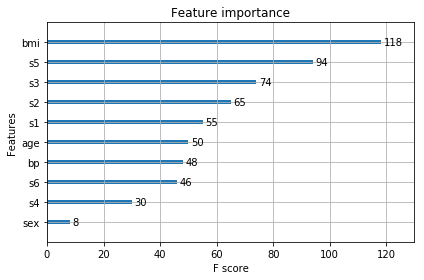

feature_importance - END


In [83]:
def xgboost_regression():
    data = run_load_data()
    train_df, test_df = run_train_test_split(data) # Don't have to run this if you given data is already splitted into train & test
    train_df, test_df = run_pre_processing(train_df, test_df)
    X_train, y_train, X_test, y_test = run_x_y_split(train_df, test_df)
    if over_sampling:
        X_train, y_train = run_over_sampling(X_train, y_train)
    best_learning_rate, best_max_depth, best_n_estimators, best_gamma, best_colsample_bytree,  best_colsample_bylevel = run_grid_search(X_train, y_train)
    run_cross_validation(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_gamma, best_colsample_bytree, best_colsample_bylevel)
    model = run_train_model(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_gamma, best_colsample_bytree, best_colsample_bylevel)
    prediction = run_prediction(model, X_test)
    run_model_evaluation_on_test(prediction, y_test)
    run_feature_importance(model)
xgboost_regression()